PART 1: Preliminary data analysis

Part 1 is aimed at supporting data analysis and value normalization. There are elements such as dataset visualizations, numerical analysis, value mapping and much more

In [144]:
# Import libraries

from keras import layers
from keras.optimizers import SGD
from keras.layers import Dense
from keras.models import Sequential
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_curve, auc
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from shap.plots import waterfall
import shap
import warnings
warnings.filterwarnings("ignore")

In [145]:
# Read dataset 'bank_data_prediction_task.csv'

df = pd.read_csv('Data/bank_data_prediction_task.csv', low_memory=False)
print(df.head(10))

   Unnamed: 0  age          job  marital    education  default housing loan  \
0           1   37     services  married  high.school       no     yes   no   
1           2   56     services  married  high.school       no      no  yes   
2           3   41  blue-collar  married      unknown  unknown      no   no   
3           4   25     services   single  high.school       no     yes   no   
4           5   25     services   single  high.school       no     yes   no   
5           6   35  blue-collar  married     basic.6y       no     yes   no   
6           7   54      retired  married     basic.9y  unknown     yes  yes   
7           8   46  blue-collar  married     basic.6y  unknown     yes  yes   
8           9   41   technician   single  high.school       no     yes   no   
9          10   37       admin.  married  high.school       no     yes   no   

     contact month  ... pdays  previous     poutcome  emp.var.rate  \
0  telephone   may  ...   999         0  nonexistent        

In [146]:
# count client answers

df.y.value_counts()

y
no     36020
yes     5168
Name: count, dtype: int64

In [147]:
# Show data statistics

df.describe()

,Unnamed: 0,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.00000,16476.000000,16476.000000,41188.000000,41188.000000,41188.000000,40938.000000,41188.000000,41188.000000,41188.000000
mean,20594.50000,40.02406,259.660172,2.546856,962.475454,0.172963,0.081886,93.575950,-40.502600,3.621291,5167.035911
std,11890.09578,10.42125,260.660561,2.699664,186.910907,0.494901,1.570960,0.578889,4.628198,1.734447,72.251528
min,1.00000,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,10297.75000,32.00000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,20594.50000,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,30891.25000,47.00000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,41188.00000,98.00000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [148]:
# Show data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         41188 non-null  int64  
 1   age                41188 non-null  int64  
 2   job                41188 non-null  object 
 3   marital            41188 non-null  object 
 4   education          41188 non-null  object 
 5   default            41188 non-null  object 
 6   housing            41188 non-null  object 
 7   loan               41188 non-null  object 
 8   contact            16476 non-null  object 
 9   month              16476 non-null  object 
 10  day_of_week        16476 non-null  object 
 11  duration           16476 non-null  float64
 12  campaign           16476 non-null  float64
 13  pdays              41188 non-null  int64  
 14  previous           41188 non-null  int64  
 15  poutcome           41188 non-null  object 
 16  emp.var.rate       411

In [149]:
# Count and show empty cells

df.isnull().sum()

Unnamed: 0               0
age                      0
job                      0
marital                  0
education                0
default                  0
housing                  0
loan                     0
contact              24712
month                24712
day_of_week          24712
duration             24712
campaign             24712
pdays                    0
previous                 0
poutcome                 0
emp.var.rate             0
cons.price.idx         250
cons.conf.idx            0
euribor3m                0
nr.employed              0
y                        0
test_control_flag        0
dtype: int64

In [150]:
# Data normalization, filling and mapping

df['job'] = df['job'].map({job: x for x, job in enumerate(
    ["retired", "admin.", "entrepreneur", "management", "self-employed", "technician", "blue-collar", "housemaid",
     "services", "student", "unemployed", "unknown"])})
df['marital'] = df['marital'].map({job: x for x, job in enumerate(["divorced", "married", "single", "unknown"])})
df['education'] = df['education'].map({job: x for x, job in enumerate(
    ["illiterate", "basic.4y", "basic.6y", "basic.9y", "unknown", "high.school", "university.degree",
     "professional.course"])})
df['default'] = df['default'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['housing'] = df['housing'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['loan'] = df['loan'].apply(lambda x: 2 if x == "yes" else (0 if x == "no" else 1))
df['contact'] = df['contact'].map({job: x for x, job in enumerate(df['contact'].unique())})
df['month'] = df['month'].map({job: x for x, job in enumerate(df['month'].unique())})
df['day_of_week'] = df['day_of_week'].map({job: x for x, job in enumerate(df['day_of_week'].unique())})
df['poutcome'] = df['poutcome'].apply(lambda x: 2 if x == "success" else (0 if x == "failure" else 1))
df['y'] = df['y'].apply(lambda x: 1 if x == "yes" else 0)
df['cons.price.idx'] = df['cons.price.idx'].fillna(df['cons.price.idx'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         41188 non-null  int64  
 1   age                41188 non-null  int64  
 2   job                41188 non-null  int64  
 3   marital            41188 non-null  int64  
 4   education          41188 non-null  int64  
 5   default            41188 non-null  int64  
 6   housing            41188 non-null  int64  
 7   loan               41188 non-null  int64  
 8   contact            41188 non-null  int64  
 9   month              41188 non-null  int64  
 10  day_of_week        41188 non-null  int64  
 11  duration           16476 non-null  float64
 12  campaign           16476 non-null  float64
 13  pdays              41188 non-null  int64  
 14  previous           41188 non-null  int64  
 15  poutcome           41188 non-null  int64  
 16  emp.var.rate       411

In [151]:
# Checking the number of customers in the control group and in the campaign group

df.groupby(['test_control_flag'])['test_control_flag'].count()

test_control_flag
campaign group    16476
control group     24712
Name: test_control_flag, dtype: int64

In [152]:
# Display the percentage of subscribing and non-subscribing clients in control group

df_Control_group = df[df['test_control_flag'] == "control group"]
Control_results = df_Control_group.groupby(['y'])['y'].count()
Control_percentage_results = (Control_results / Control_results.sum()) * 100
print("Clients from control group did not subscribed a term deposit: "
      + str(round(Control_results[0]))
      + " (" + str(round(Control_percentage_results[0], 2)) + "%)")
print("Clients from control group subscribed a term deposit: "
      + str(round(Control_results[1]))
      + " (" + str(round(Control_percentage_results[1], 2)) + "%)")

Clients from control group did not subscribed a term deposit: 22028 (89.14%)
Clients from control group subscribed a term deposit: 2684 (10.86%)


In [153]:
# Display the percentage of subscribing and non-subscribing clients in campaign group

df_Campaign_group = df[df['test_control_flag'] == "campaign group"]
Campaign_results = df_Campaign_group.groupby(['y'])['y'].count()
Campaign_percentage_results = (Campaign_results / Campaign_results.sum()) * 100
print("Clients from campaign group did not subscribed a term deposit: "
      + str(round(Campaign_results[0]))
      + " (" + str(round(Campaign_percentage_results[0], 2)) + "%)")
print("Clients from campaign group subscribed a term deposit: "
      + str(round(Campaign_results[1]))
      + " (" + str(round(Campaign_percentage_results[1], 2)) + "%)")

Clients from campaign group did not subscribed a term deposit: 13992 (84.92%)
Clients from campaign group subscribed a term deposit: 2484 (15.08%)


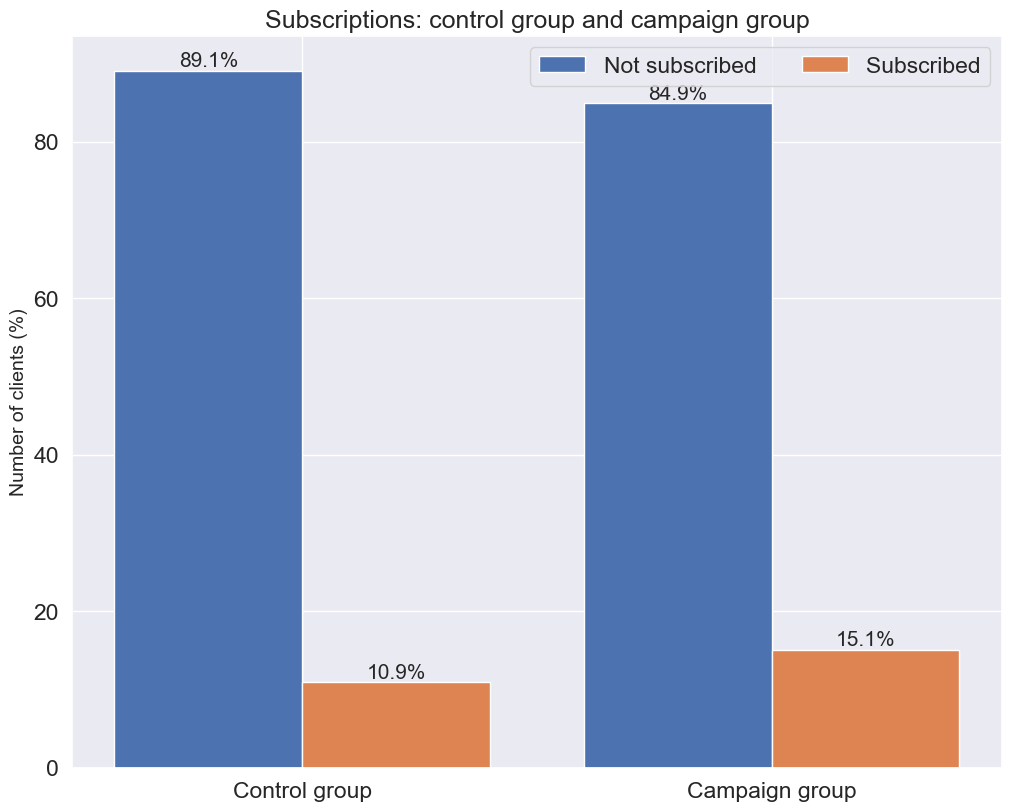

In [154]:
# Comparison on the chart of the two groups and their percentage subscriptions

types = ("Control group", "Campaign group")
values = {
    'Not subscribed': (round(Control_percentage_results[0], 1), round(Campaign_percentage_results[0], 1)),
    'Subscribed': (round(Control_percentage_results[1], 1), round(Campaign_percentage_results[1], 1)),
}

x = np.arange(len(types))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    for rect1 in rects:
        height = rect1.get_height()
        plt.annotate("{}%".format(height), (rect1.get_x() + rect1.get_width() / 2, height + .05), ha="center",
                     va="bottom", fontsize=15)
    multiplier += 1

ax.set_ylabel('Number of clients (%)', fontsize=14)
ax.set_title('Subscriptions: control group and campaign group', fontsize=18)
ax.set_xticks(x + width / 2, types)
ax.legend(loc='upper right', ncols=2)

plt.show()

PART 2: Data cleaning and analysis using ML

In [155]:
# split Control and Campaign group to train and test parts

X_train, y_train = df_Control_group.iloc[:, :-2], df_Control_group["y"]
X_train.drop(columns=['Unnamed: 0', 'contact', 'month', 'day_of_week', 'duration', 'campaign'], inplace=True)

X_test, y_test = df_Campaign_group.iloc[:, :-2], df_Campaign_group["y"]
X_test.drop(columns=['Unnamed: 0', 'contact', 'month', 'day_of_week', 'duration', 'campaign'], inplace=True)

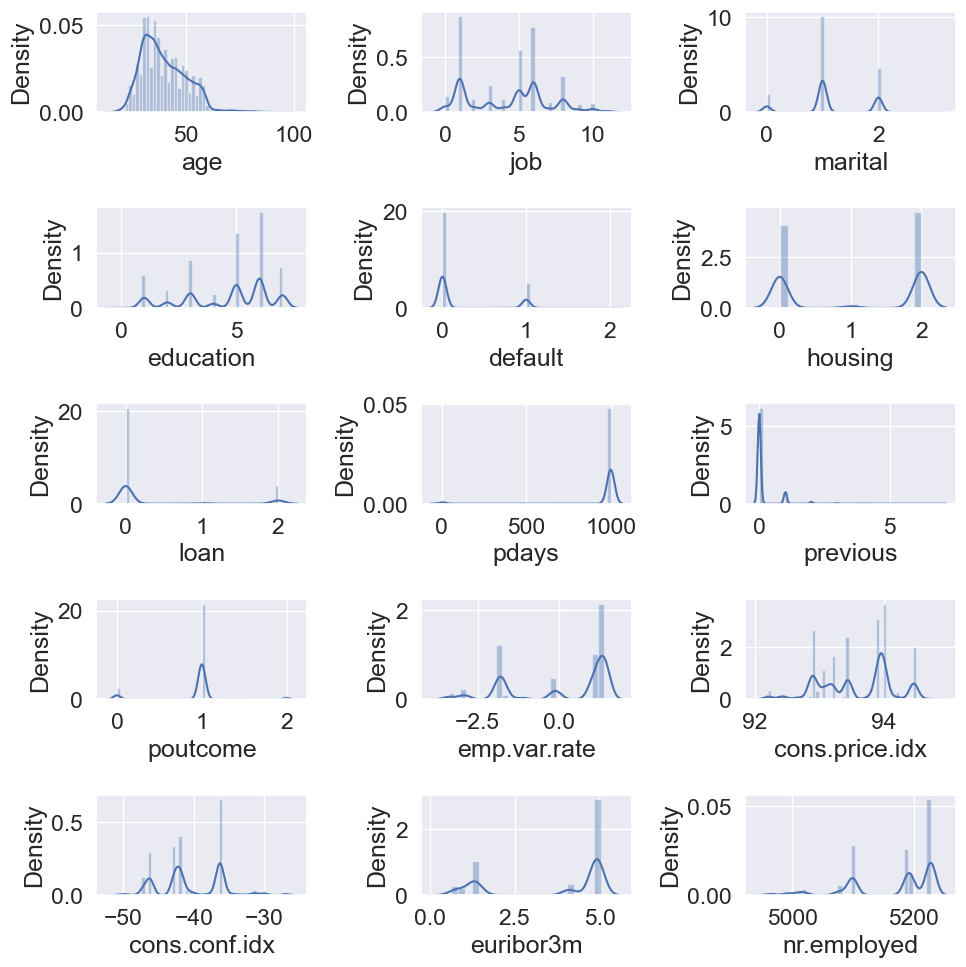

In [158]:
# Display graph statistics about attributes using in machine learning

df_tmp = pd.concat([X_train, X_test], ignore_index=True, sort=False)
fig, axs = plt.subplots(ncols=3, nrows=5, figsize=(10, 10))
index = 0
axs = axs.flatten()
for k,v in df_tmp.items():
    sns.distplot(v, ax=axs[index])
    index = index + 1
plt.tight_layout()

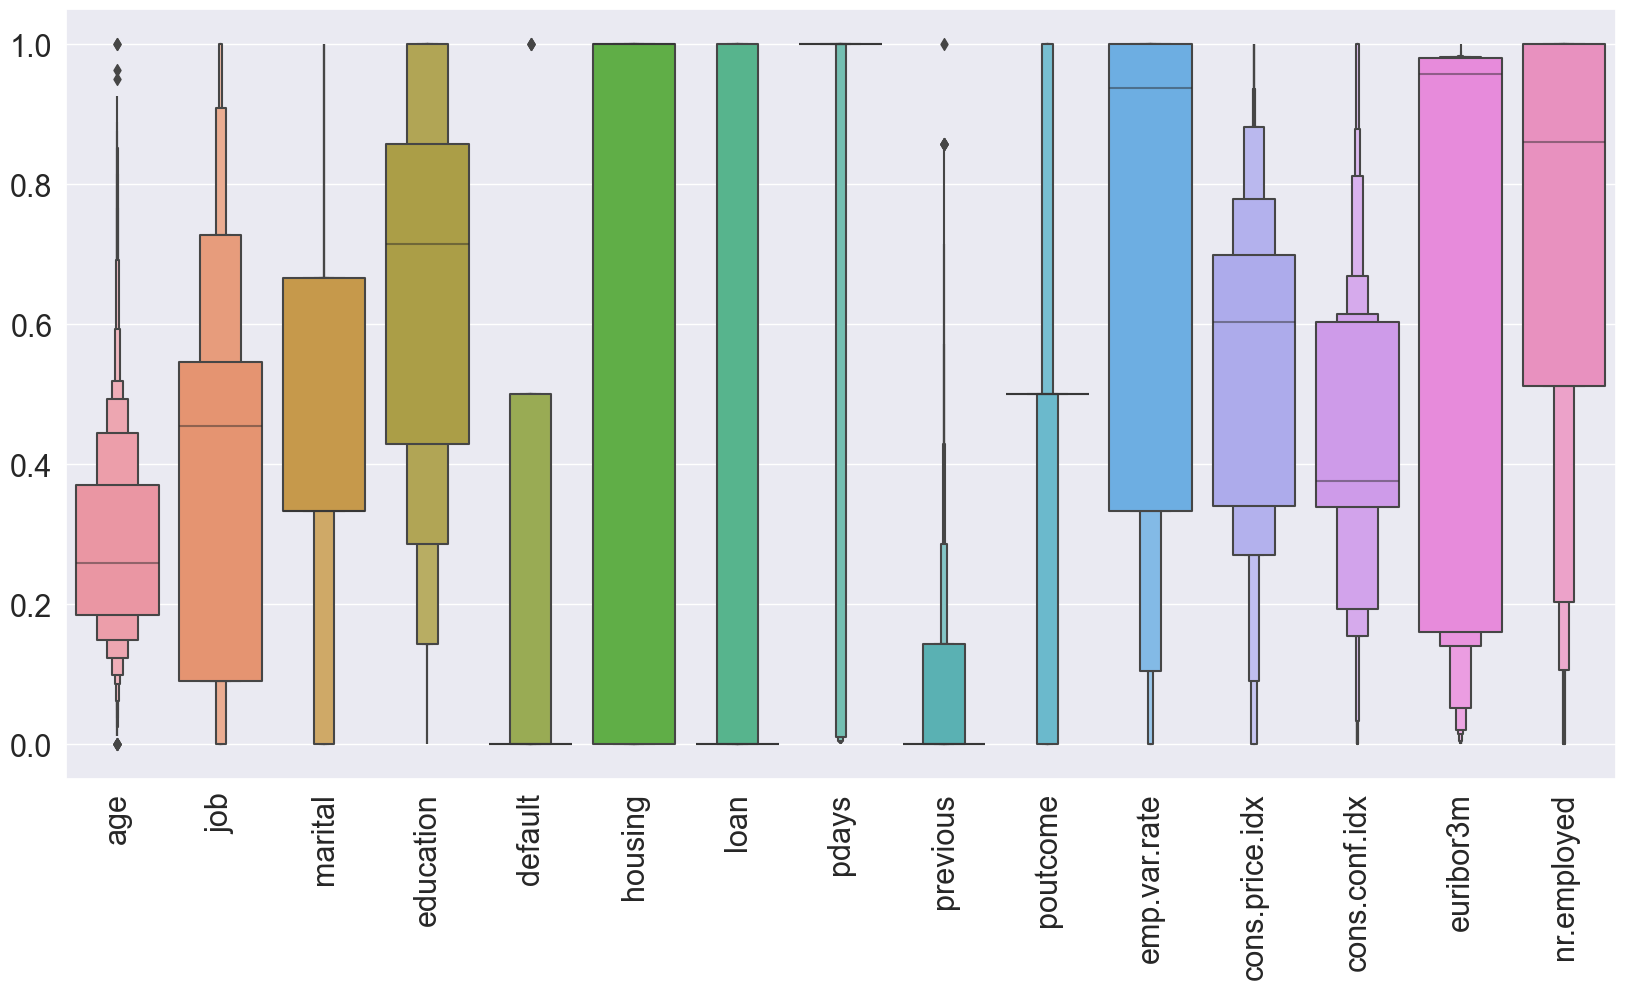

In [93]:
# Display outliers for normalized data

df_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_tmp), index=df_tmp.index, columns=df_tmp.columns)
plt.figure(figsize=(20, 10))
sns.boxenplot(data=df_scaled)
plt.xticks(rotation=90)
plt.show()

In [94]:
# Scale train and test parts separately

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
print(X_train.head(5))

            age       job   marital  education  default  housing  loan  pdays  \
16476  0.481481  0.636364  0.333333   0.142857      0.0      0.0   0.0    1.0   
16477  0.493827  0.727273  0.333333   0.714286      0.5      0.0   0.0    1.0   
16478  0.283951  0.090909  0.333333   0.285714      0.0      0.0   0.0    1.0   
16479  0.345679  0.727273  0.333333   0.428571      0.5      0.0   0.0    1.0   
16480  0.518519  0.090909  0.333333   1.000000      0.0      0.0   0.0    1.0   

       previous  poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  \
16476       0.0       0.5        0.9375        0.698753        0.60251   
16477       0.0       0.5        0.9375        0.698753        0.60251   
16478       0.0       0.5        0.9375        0.698753        0.60251   
16479       0.0       0.5        0.9375        0.698753        0.60251   
16480       0.0       0.5        0.9375        0.698753        0.60251   

       euribor3m  nr.employed  
16476   0.957379     0.859735  
1647

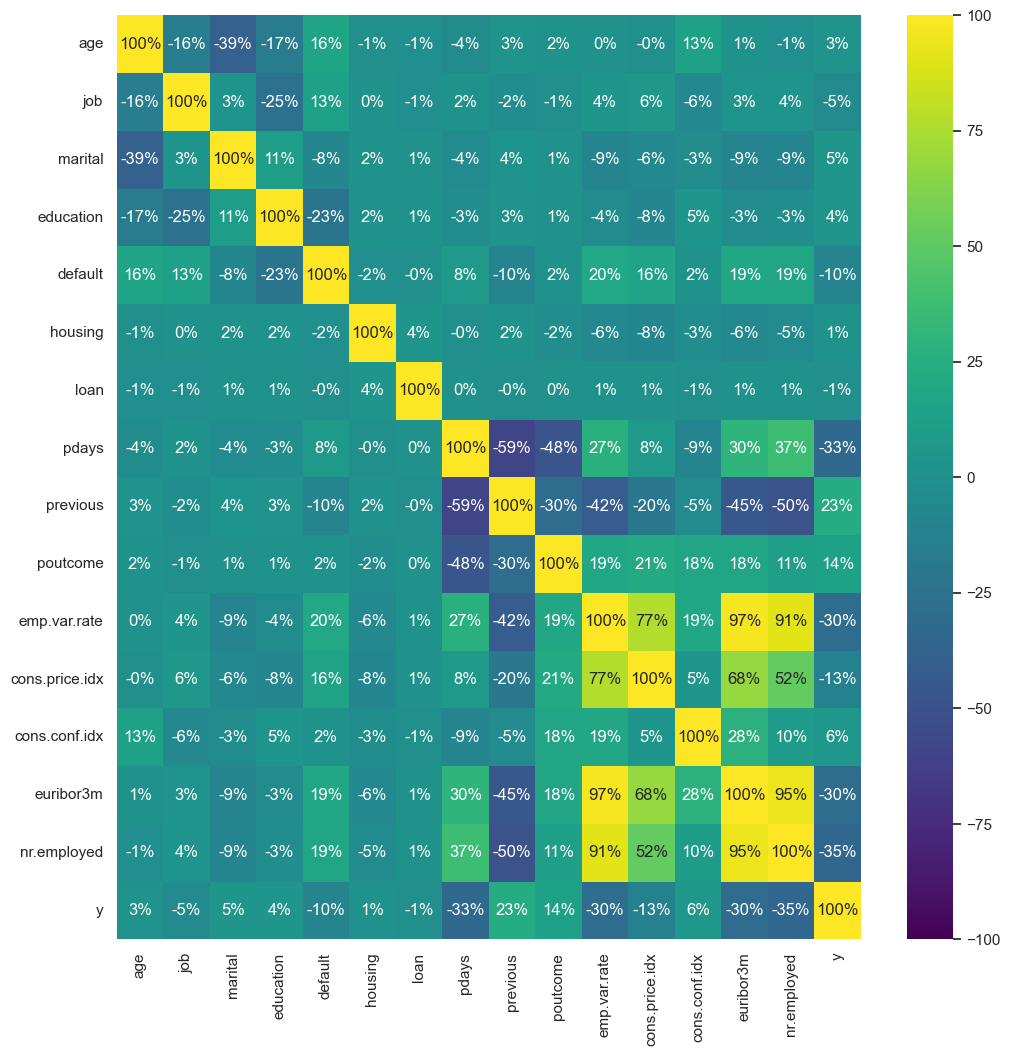

In [95]:
# Display heatmap of correlation between attributes and decision class

sns.set()
Train = X_train.copy(deep=True)
Train['y'] = y_train
fig, ax0 = plt.subplots(figsize=(12, 12))
ax = sns.heatmap(Train.corr() * 100, vmin=-100, vmax=100, annot=True, fmt=".0f", cmap='viridis')
for t in ax.texts: t.set_text(t.get_text() + "%")
plt.show()

In [96]:
# Using RF feature importances to decline attributes with very low importance (<1%)

rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({'Column': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
threshold = 0.01
selected_columns = importance_df.loc[importance_df['Importance'] >= threshold, 'Column'].tolist()

print("Selected columns:", selected_columns)

Selected columns: ['age', 'euribor3m', 'job', 'education', 'nr.employed', 'marital', 'poutcome', 'cons.conf.idx', 'pdays', 'housing', 'cons.price.idx', 'loan', 'emp.var.rate', 'previous', 'default']


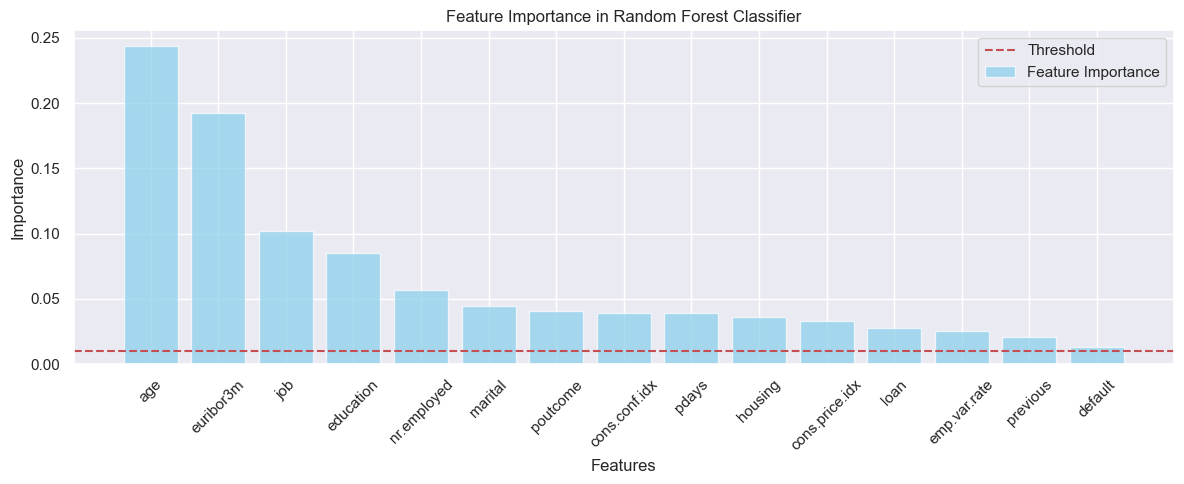

In [97]:
# Visualization of feature importances

plt.figure(figsize=(12, 5))
plt.bar(importance_df['Column'], importance_df['Importance'], color='skyblue', alpha=0.7, label='Feature Importance')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

PART 3: Machine learning

In [134]:
# Balance train data from 1:0.18 to 1:1 class ratio with oversamle SMOTETomek method

zeros = np.count_nonzero(y_train.values == 0)
X_bal, y_bal = SMOTETomek(sampling_strategy={0: zeros, 1: int(zeros * 1)}).fit_resample(X_train, y_train)

PART 3a: KNN model

Precision score: 0.27
Recall score: 0.4
Confusion matrix:
 [[11238  2754]
 [ 1488   996]]


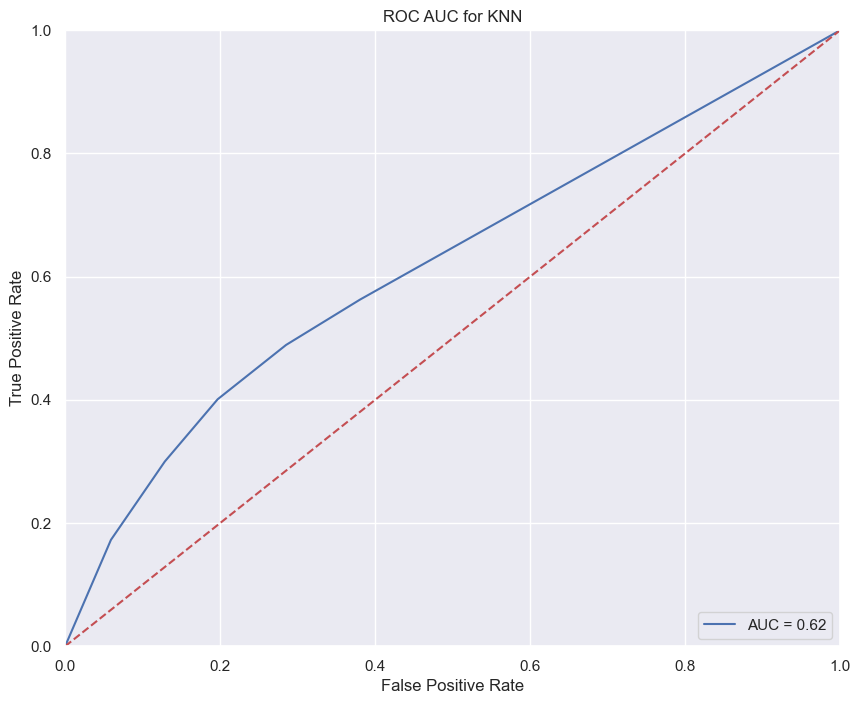

In [99]:
# Using KNN algorithm to predict campaign group answers based on control group data

KNN_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
KNN_model.fit(X_bal, y_bal)
KNN_continuous_predictions = KNN_model.predict_proba(X_test)[:, 1]
KNN_predictions = KNN_continuous_predictions > 0.5
print("Precision score:", round(precision_score(y_test, KNN_predictions), 2))
print("Recall score:", round(recall_score(y_test, KNN_predictions), 2))
print("Confusion matrix:\n", confusion_matrix(y_test, KNN_predictions))

fpr, tpr, _ = roc_curve(y_test, KNN_continuous_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC for KNN')
plt.show()

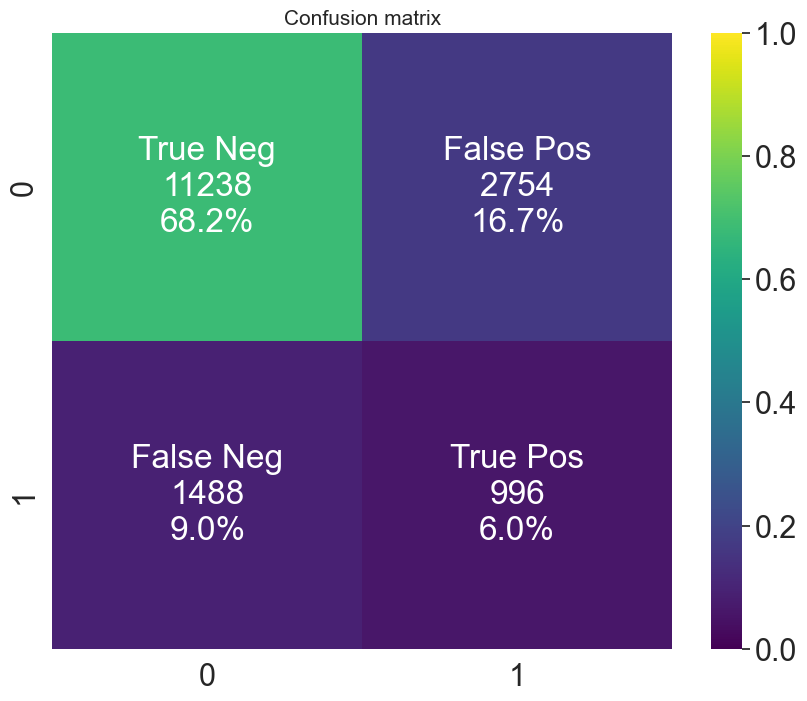

In [136]:
# Display confusion matrix for KNN model

cm=confusion_matrix(y_test, KNN_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(cm / np.sum(cm), annot=labels, vmin=0, vmax=1,
                 fmt='', cmap='viridis')
sns.set(font_scale=2)
ax.set_title('Confusion matrix', fontsize=15)
plt.show()

  0%|          | 0/51 [00:00<?, ?it/s]

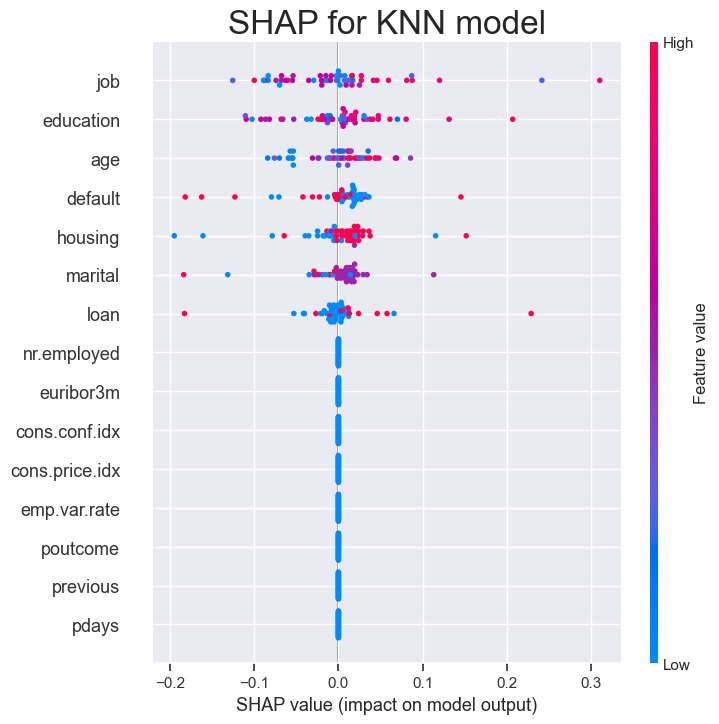

In [101]:
# SHAP plot for KNN model

num_samples = 51
explainer = shap.KernelExplainer(KNN_model.predict, X_test.iloc[:num_samples, :])
sv = explainer.shap_values(X_test.iloc[:num_samples, :])

shap.summary_plot(sv, X_test.iloc[:num_samples, :], feature_names=X_train.columns, show=False)
plt.title("SHAP for KNN model")
plt.show()

PART 3b: Linear regression (Ridge type) model

Precision score: 0.35
Recall score: 0.39
Confusion matrix:
 [[12147  1845]
 [ 1503   981]]


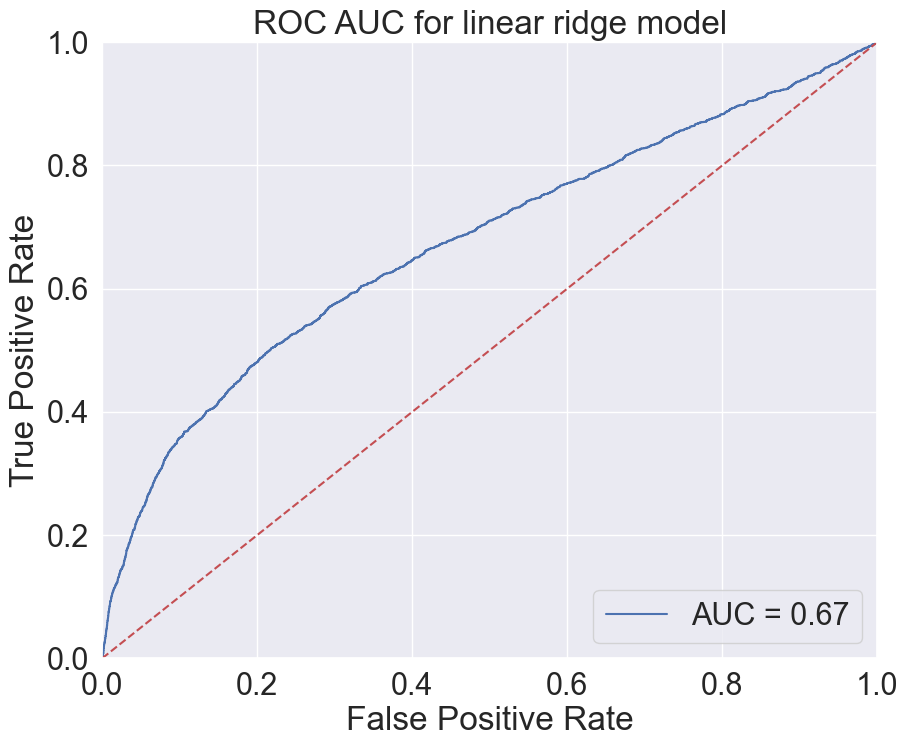

In [135]:
# Using Linear regression model algorithm to predict campaign group answers based on control group data

LR_model = linear_model.Ridge(alpha=0.2, random_state=True)
LR_model.fit(X_bal, y_bal)
LR_continuous_predictions = LR_model.predict(X_test)
LR_predictions = LR_continuous_predictions > 0.6
print("Precision score:", round(precision_score(y_test, LR_predictions), 2))
print("Recall score:", round(recall_score(y_test, LR_predictions), 2))
print("Confusion matrix:\n", confusion_matrix(y_test, LR_predictions))

fpr, tpr, _ = roc_curve(y_test, LR_continuous_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC for linear ridge model')
plt.show()

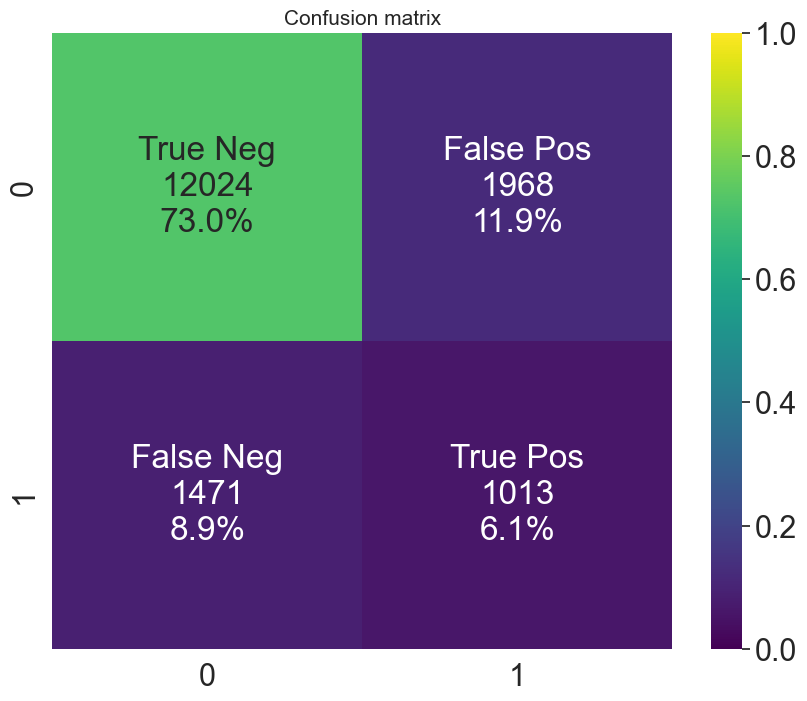

In [103]:
# Display confusion matrix for Linear regression model

cm=confusion_matrix(y_test, LR_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(cm / np.sum(cm), annot=labels, vmin=0, vmax=1,
                 fmt='', cmap='viridis')
sns.set(font_scale=2)
ax.set_title('Confusion matrix', fontsize=15)
plt.show()

Using 151 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/151 [00:00<?, ?it/s]

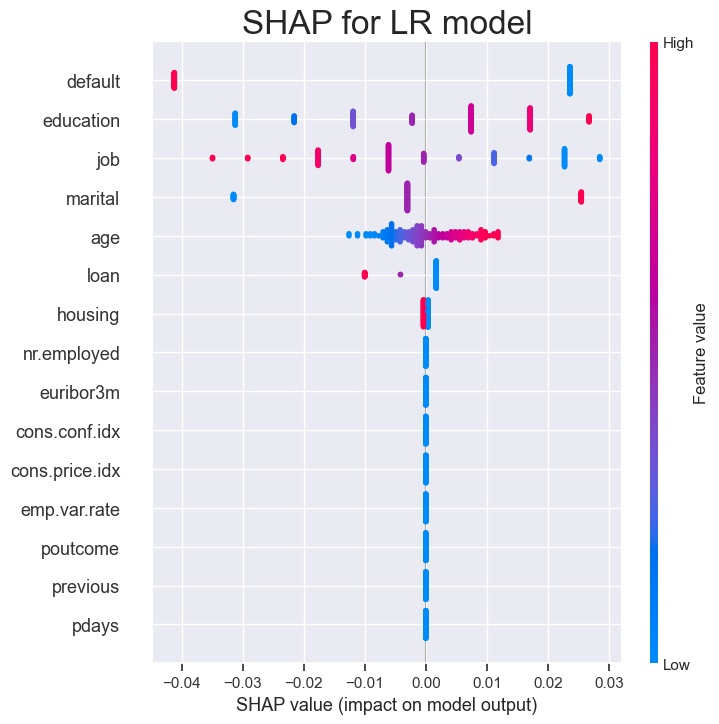

In [104]:
# SHAP plot for LR model

num_samples = 151
explainer = shap.KernelExplainer(LR_model.predict, X_test.iloc[:num_samples, :])
sv = explainer.shap_values(X_test.iloc[:num_samples, :])

shap.summary_plot(sv, X_test.iloc[:num_samples, :], feature_names=X_train.columns, show=False)
plt.title("SHAP for LR model")
plt.show()

PART 3c: Random forest model

Precision score: 0.38
Recall score: 0.39
Confusion matrix:
 [[12409  1583]
 [ 1503   981]]


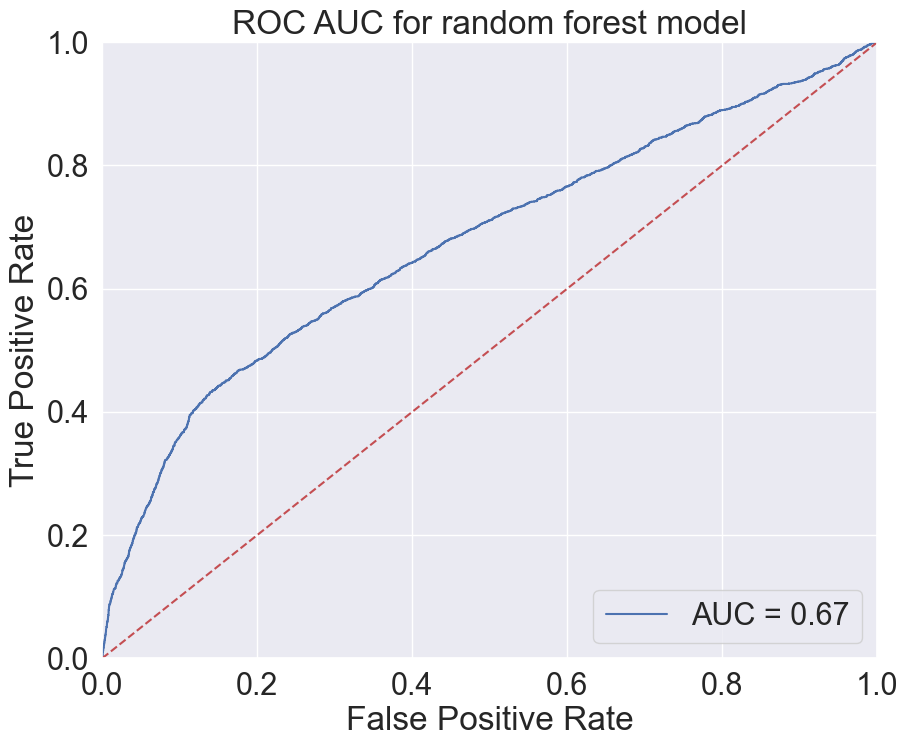

In [105]:
# Using Random Forest model algorithm to predict campaign group answers based on control group data

RF_model = RandomForestClassifier(n_estimators=200, max_depth=8)
RF_model.fit(X_bal, y_bal)
RF_continuous_predictions = RF_model.predict_proba(X_test)[:, 1]
RF_predictions = RF_continuous_predictions > 0.5
print("Precision score:", round(precision_score(y_test, RF_predictions), 2))
print("Recall score:", round(recall_score(y_test, RF_predictions), 2))
print("Confusion matrix:\n", confusion_matrix(y_test, RF_predictions))

fpr, tpr, _ = roc_curve(y_test, RF_continuous_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC for random forest model')
plt.show()

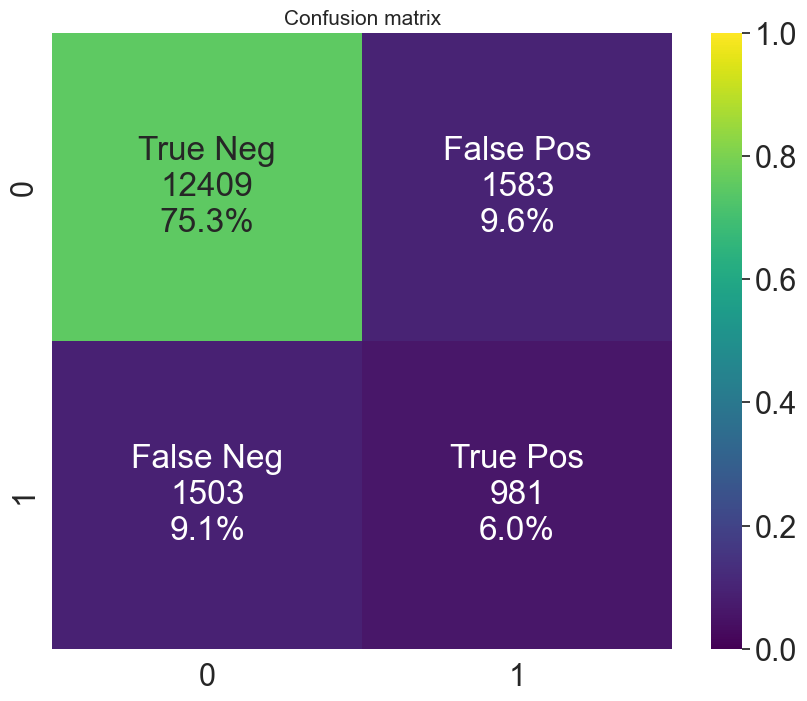

In [106]:
# Display confusion matrix for Random forest model

cm=confusion_matrix(y_test, RF_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(cm / np.sum(cm), annot=labels, vmin=0, vmax=1,
                 fmt='', cmap='viridis')
sns.set(font_scale=2)
ax.set_title('Confusion matrix', fontsize=15)
plt.show()

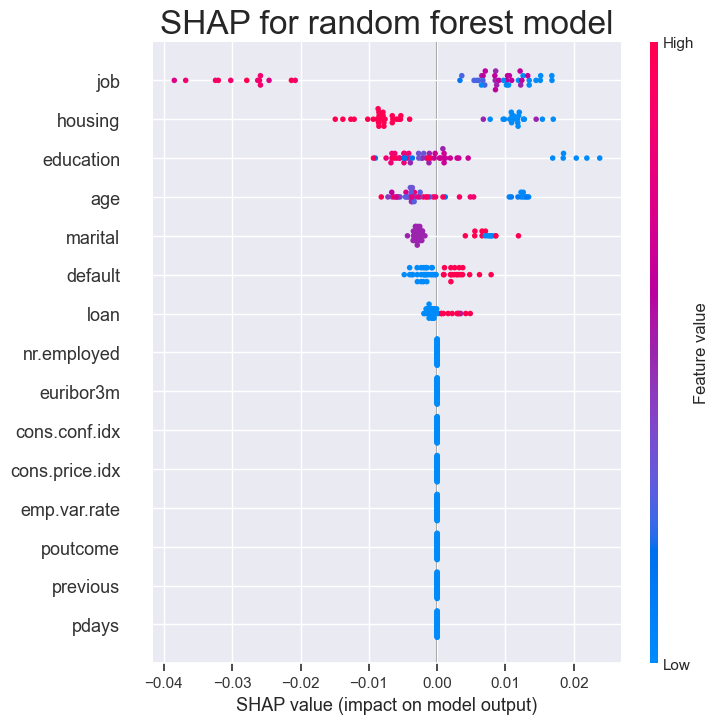

In [107]:
# SHAP plot for random forest model

num_samples = 50
explainer = shap.TreeExplainer(RF_model, X_test.iloc[:num_samples, :])
sv = explainer.shap_values(X_test.iloc[:num_samples, :])

shap.summary_plot(sv[0], X_test.iloc[:num_samples, :], feature_names=X_test.columns, show=False)
plt.title("SHAP for random forest model")
plt.show()

PART 3d: XGB model

Precision score: 0.45
Recall score: 0.21
Confusion matrix:
 [[13354   638]
 [ 1970   514]]


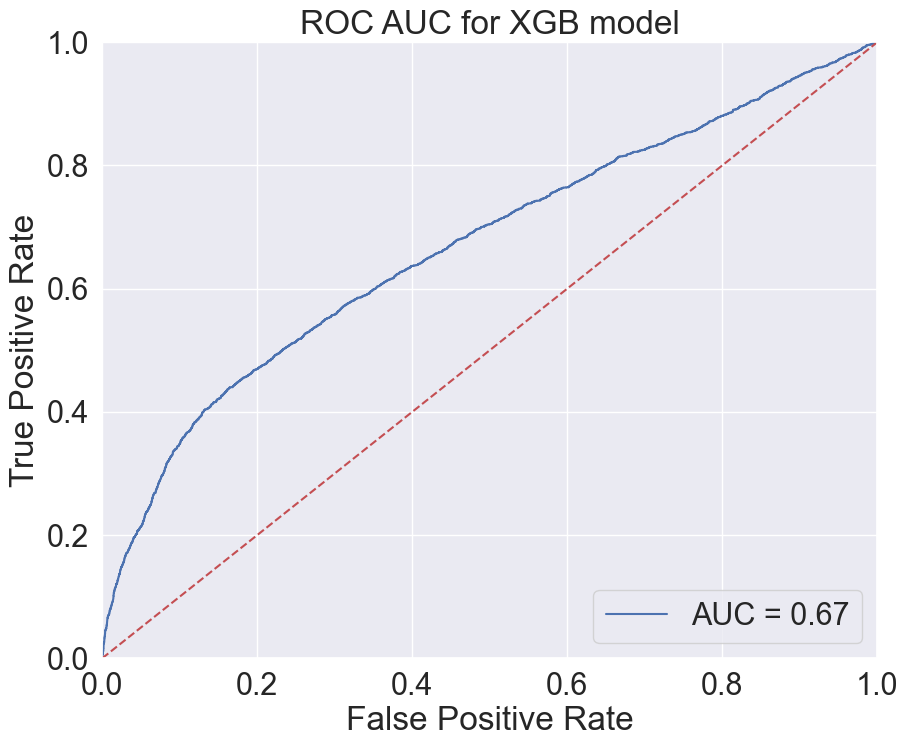

In [108]:
# Using XGB model to predict campaign group answers based on control group data

XGB_model = XGBClassifier()
XGB_model.fit(X_bal, y_bal)
XGB_continuous_predictions = XGB_model.predict_proba(X_test)[:, 1]
XGB_predictions = XGB_continuous_predictions > 0.5
print("Precision score:", round(precision_score(y_test, XGB_predictions), 2))
print("Recall score:", round(recall_score(y_test, XGB_predictions), 2))
print("Confusion matrix:\n", confusion_matrix(y_test, XGB_predictions))

fpr, tpr, _ = roc_curve(y_test, XGB_continuous_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC for XGB model')
plt.show()

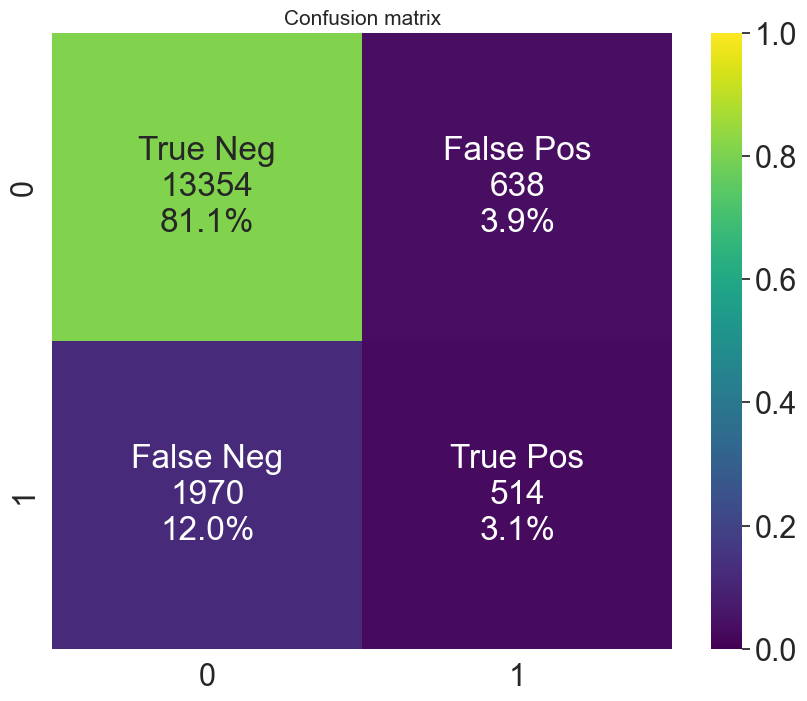

In [109]:
# Display confusion matrix for XGB model

cm=confusion_matrix(y_test, XGB_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(cm / np.sum(cm), annot=labels, vmin=0, vmax=1,
                 fmt='', cmap='viridis')
sns.set(font_scale=2)
ax.set_title('Confusion matrix', fontsize=15)
plt.show()

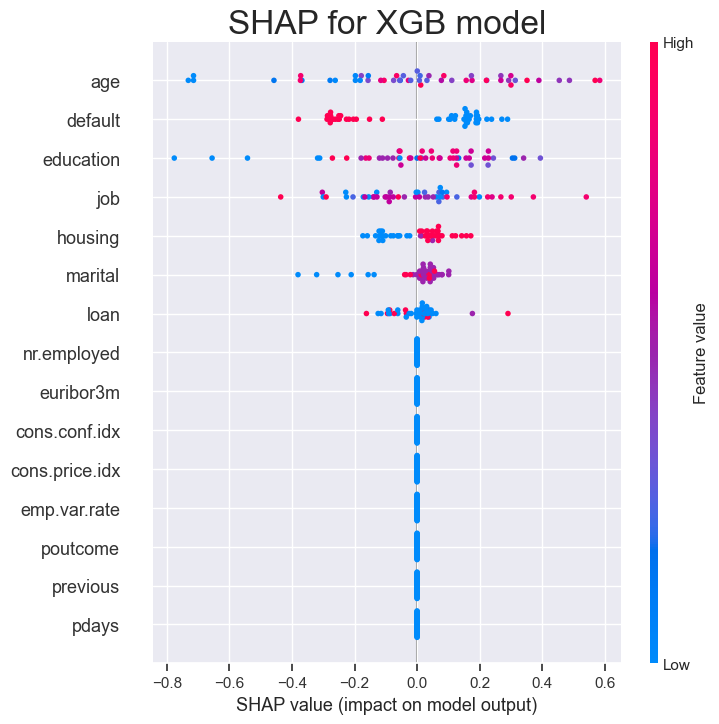

In [110]:
# SHAP plot for XGB model

num_samples = 50
explainer = shap.TreeExplainer(XGB_model, X_test.iloc[:num_samples, :])
sv = explainer.shap_values(X_test.iloc[:num_samples, :])

shap.summary_plot(sv, X_test.iloc[:num_samples, :], feature_names=X_train.columns, show=False)
plt.title("SHAP for XGB model")
plt.show()

PART 3e: Neural network model

Epoch 1/25
1076/1076 [==============================] - 6s 5ms/step - loss: 0.6767 - val_loss: 0.6625
Epoch 2/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.6536 - val_loss: 0.6433
Epoch 3/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.6358 - val_loss: 0.6280
Epoch 4/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.6223 - val_loss: 0.6155
Epoch 5/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.6106 - val_loss: 0.6054
Epoch 6/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.6014 - val_loss: 0.5972
Epoch 7/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.5938 - val_loss: 0.5905
Epoch 8/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.5885 - val_loss: 0.5852
Epoch 9/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.5831 - val_loss: 0.5809
Epoch 10/25
1076/1076 [==============================] - 5s 5ms/step - loss: 0.580

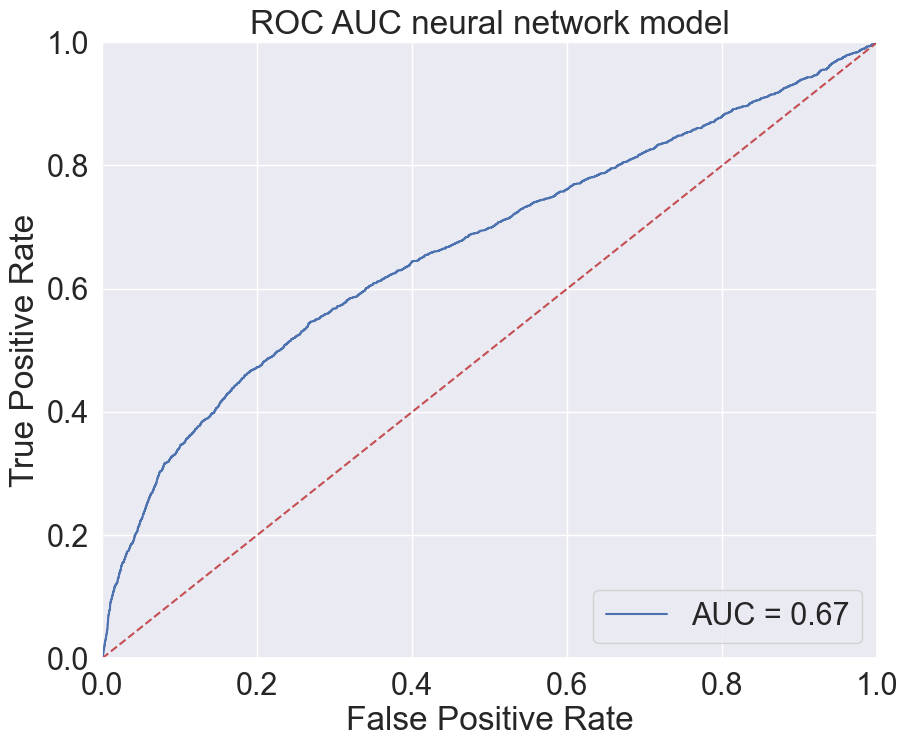

In [111]:
# Using Neural Network model to predict campaign group answers based on control group data

NN_model = Sequential()
NN_model.add(Dense(512, input_shape=(X_train.shape[1],), activation="relu"))
NN_model.add(layers.Dropout(0.4))
NN_model.add(Dense(1, activation='sigmoid'))
NN_model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.0001, momentum=0.85))

X_tr, X_val, y_tr, y_val = train_test_split(X_bal, y_bal, test_size=0.2, stratify=y_bal, shuffle=True)
history = NN_model.fit(X_tr, y_tr, epochs=25, verbose=1, batch_size=32, validation_data=[X_val, y_val])

NN_continuous_predictions = NN_model.predict(X_test, verbose=0)
NN_predictions = NN_continuous_predictions > 0.6

print("Precision score:", round(precision_score(y_test, NN_predictions), 2))
print("Recall score:", round(recall_score(y_test, NN_predictions), 2))
print("Confusion matrix:\n", confusion_matrix(y_test, NN_predictions))

fpr, tpr, _ = roc_curve(y_test, NN_continuous_predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC neural network model')
plt.show()

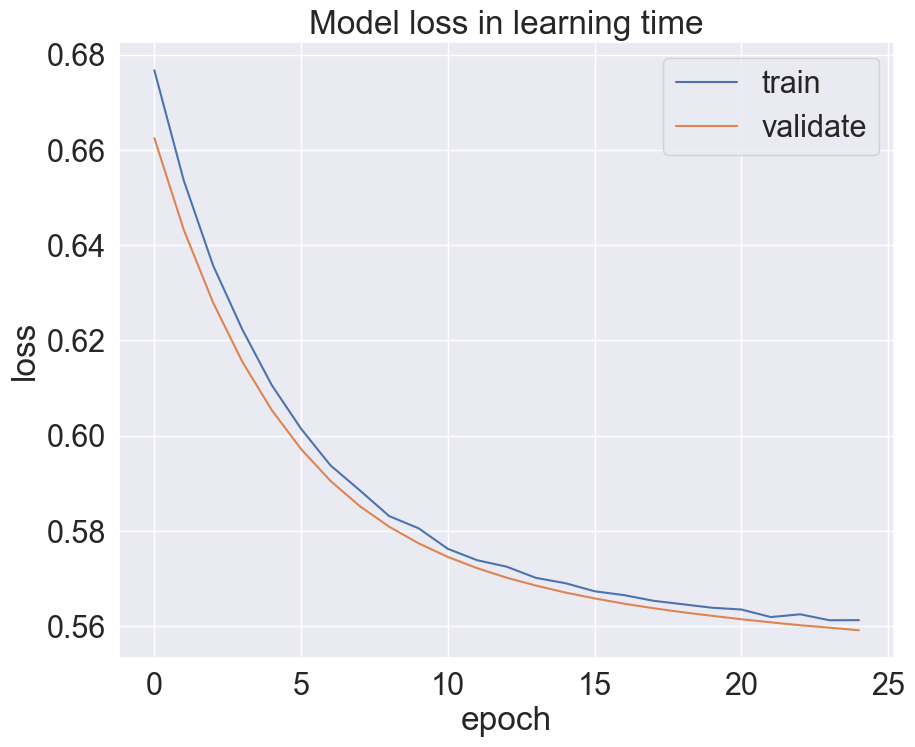

In [112]:
# Display Neural Neuron model loss in each epoch

plt.rcParams["figure.figsize"] = (10, 8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss in learning time')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='best')
plt.show()

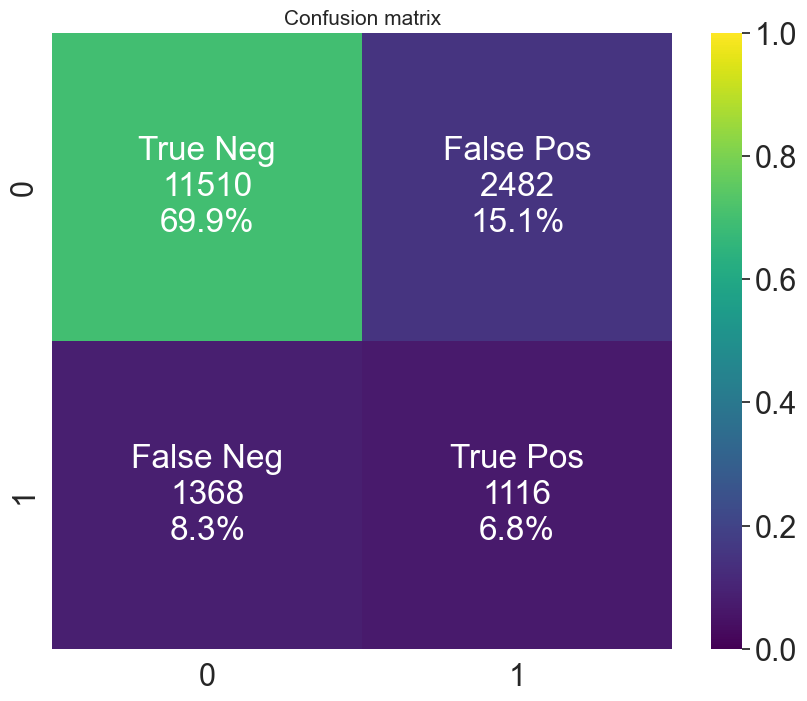

In [113]:
# Display confusion matrix for Neural network model

cm=confusion_matrix(y_test, NN_predictions)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten() / np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(cm / np.sum(cm), annot=labels, vmin=0, vmax=1,
                 fmt='', cmap='viridis')
sns.set(font_scale=2)
ax.set_title('Confusion matrix', fontsize=15)
plt.show()

2/2 [==============================] - 0s 3ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

197/197 [==============================] - 0s 2ms/step


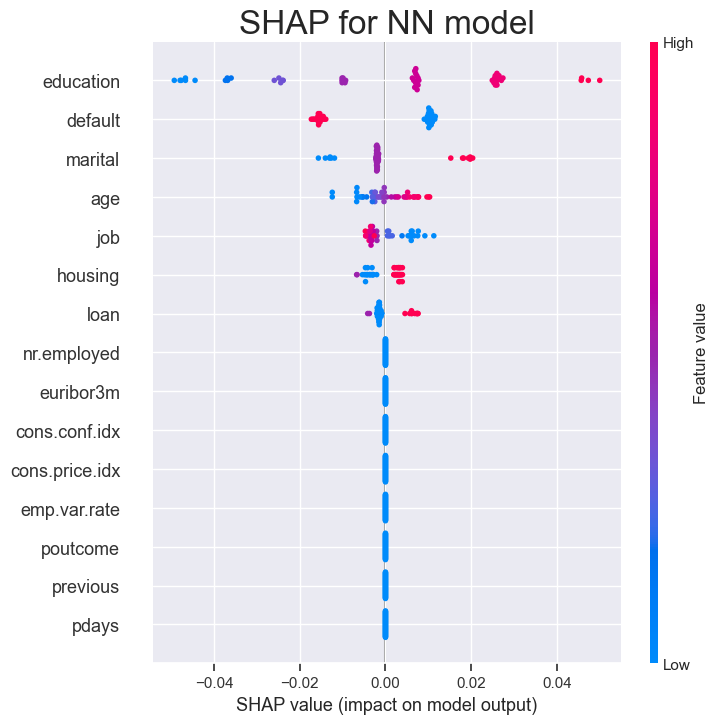

In [114]:
# SHAP plot for NN model

num_samples = 50
explainer = shap.KernelExplainer(NN_model.predict, X_test.iloc[:num_samples, :])
sv = explainer.shap_values(X_test.iloc[:num_samples, :])

shap.summary_plot(sv[0], X_test.iloc[:num_samples, :], feature_names=X_train.columns, show=False)
plt.title("SHAP for NN model")
plt.show()

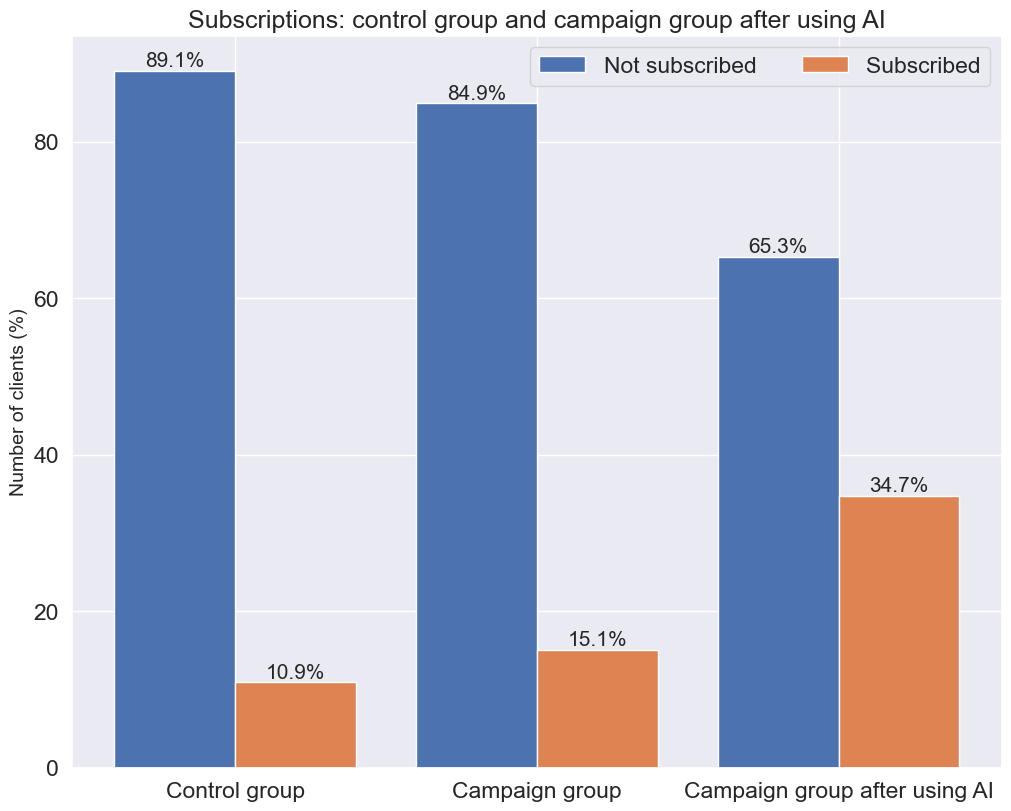

In [142]:
# Comparison on the chart of the three clients groups and their percentage subscriptions

LR_pred=confusion_matrix(y_test, LR_predictions)

Control_percentage_results_with_AI= [(LR_pred[0][1] / (LR_pred[0][1] + LR_pred[1][1])) * 100,
                                     (LR_pred[1][1] / (LR_pred[0][1] + LR_pred[1][1])) * 100]

types = ("Control group","Campaign group", "Campaign group after using AI")
values = {
    'Not subscribed': (round(Control_percentage_results[0], 1), round(Campaign_percentage_results[0], 1),
                       round(Control_percentage_results_with_AI[0],1)),
    'Subscribed': (round(Control_percentage_results[1], 1),round(Campaign_percentage_results[1], 1),
                   round(Control_percentage_results_with_AI[1],1)),
}

x = np.arange(len(types))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    for rect1 in rects:
        height = rect1.get_height()
        plt.annotate("{}%".format(height), (rect1.get_x() + rect1.get_width() / 2, height + .05), ha="center",
                     va="bottom", fontsize=15)
    multiplier += 1
sns.set(font_scale=1)
ax.set_ylabel('Number of clients (%)', fontsize=14)
ax.set_title('Subscriptions: control group and campaign group after using AI', fontsize=18)
ax.set_xticks(x + width / 2, types)
ax.legend(loc='upper right', ncols=3)

plt.show()